In [1]:
import evaluate
import nltk
import numpy as np
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import pandas as pd
nltk.download('punkt')

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\sapan\anaconda3\envs\gpuenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sapan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def compute_all_metrics(references, candidates):
    scores = {}

    # --- ROUGE ---
    rouge_result = rouge.compute(predictions=candidates, references=references, use_stemmer=True)
    scores.update({f"{k.upper()}": round(v, 4) for k, v in rouge_result.items()})

    # --- BLEU ---
    bleu_result = bleu.compute(predictions=candidates, references=references)
    scores["BLEU"] = round(bleu_result["bleu"], 4)

    # --- METEOR ---
    meteor_result = meteor.compute(predictions=candidates, references=references)
    scores["METEOR"] = round(meteor_result["meteor"], 4)

    # --- BERTScore ---
    bs_result = bertscore.compute(predictions=candidates, references=references, lang="en")
    scores["BERTScore_F1"] = round(np.mean(bs_result["f1"]), 4)

    # --- Cosine Similarity (SBERT) ---
    ref_embs = sbert_model.encode(references, convert_to_tensor=True)
    cand_embs = sbert_model.encode(candidates, convert_to_tensor=True)
    cosine_scores = util.cos_sim(ref_embs, cand_embs).diagonal()
    scores["Cosine_Similarity"] = round(cosine_scores.cpu().numpy().mean(), 4)



    return scores

In [3]:


# Load your dataset
df = pd.read_csv("multi_model_summaries.csv")  # Update path

# Define model-generated columns
model_cols = ['t5_summary', 'pegasus_summary', 'flan-t5_summary', 'distilbart_summary']
reference_col = 'summary'

# Store metrics
all_scores = []

for model_col in model_cols:
    print(f"\n🔍 Evaluating {model_col} vs. human reference...")
    metrics = compute_all_metrics(
        references=df[reference_col].astype(str).tolist(),
        candidates=df[model_col].astype(str).tolist()
    )
    metrics["model"] = model_col
    all_scores.append(metrics)

# Convert to DataFrame
score_df = pd.DataFrame(all_scores)
score_df = score_df[['model'] + [col for col in score_df.columns if col != 'model']]  # reorder
print(score_df)



🔍 Evaluating t5_summary vs. human reference...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔍 Evaluating pegasus_summary vs. human reference...

🔍 Evaluating flan-t5_summary vs. human reference...

🔍 Evaluating distilbart_summary vs. human reference...
                model  ROUGE1  ROUGE2  ROUGEL  ROUGELSUM    BLEU  METEOR  \
0          t5_summary  0.4067  0.1956  0.2971     0.2973  0.1736  0.3494   
1     pegasus_summary  0.3910  0.1796  0.2860     0.2859  0.1392  0.3356   
2     flan-t5_summary  0.2118  0.0833  0.1706     0.1704  0.0129  0.1165   
3  distilbart_summary  0.3959  0.1742  0.2733     0.2734  0.1352  0.3570   

   BERTScore_F1  Cosine_Similarity  
0        0.8797             0.7218  
1        0.8649             0.7046  
2        0.8488             0.5667  
3        0.8718             0.7127  


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


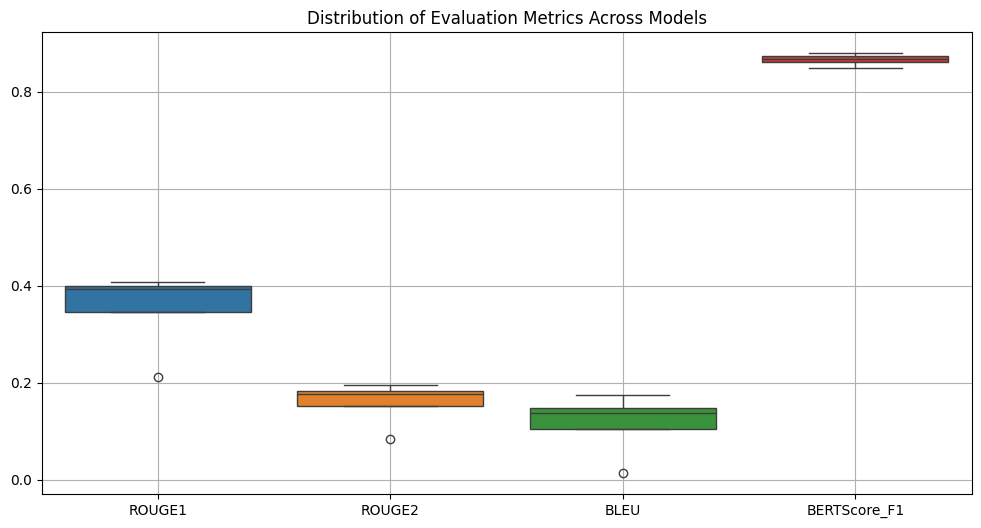

In [5]:
metrics_to_plot = ['ROUGE1', 'ROUGE2', 'BLEU', 'BERTScore_F1']

plt.figure(figsize=(12, 6))
sns.boxplot(data=score_df[metrics_to_plot])
plt.title("Distribution of Evaluation Metrics Across Models")
plt.grid(True)
plt.show()


C:\Users\sapan\AppData\Local\Temp\ipykernel_30392\2281909302.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sapan\anaconda3\envs\gpuenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


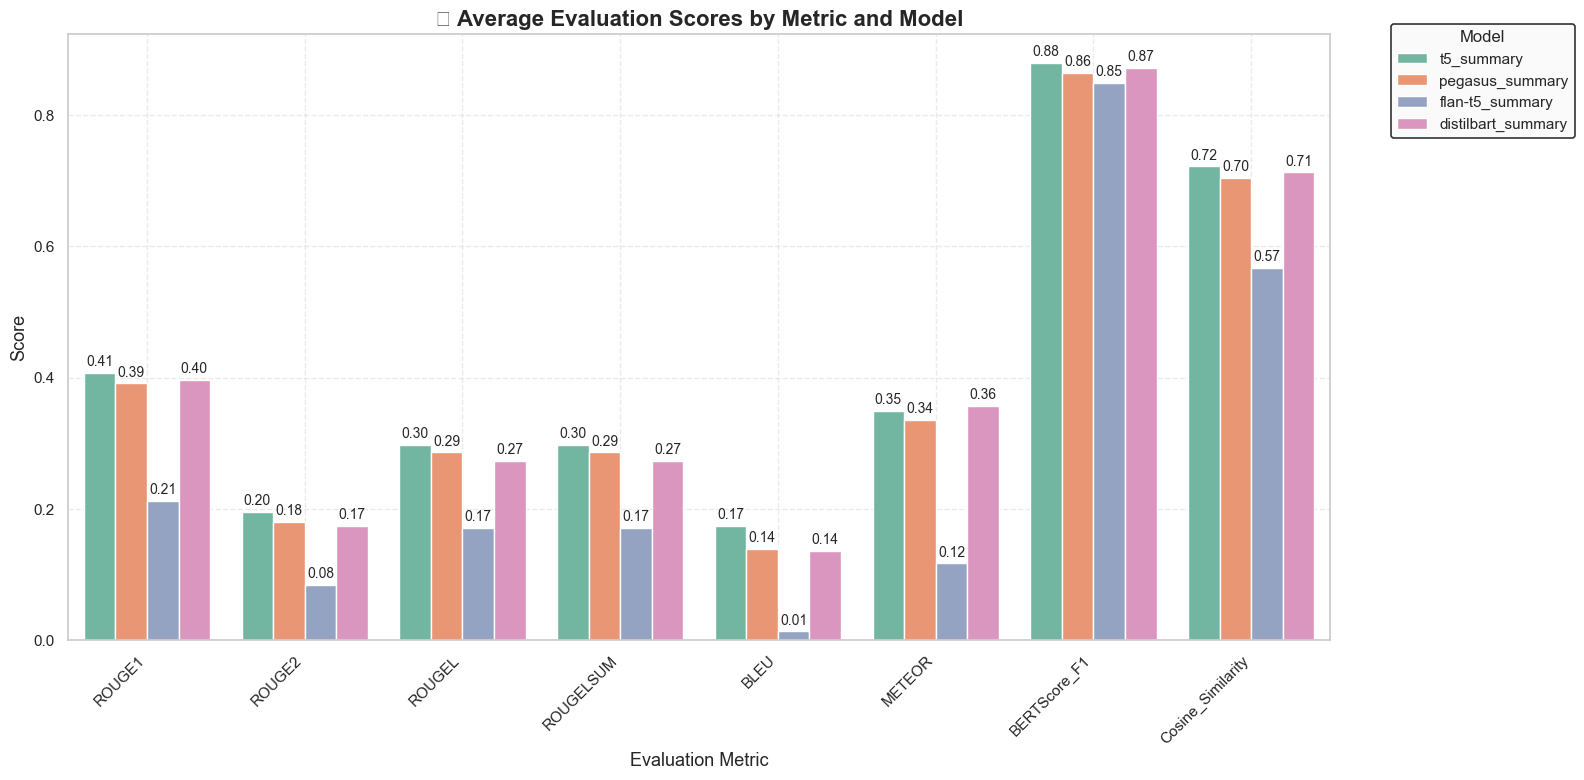

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove any unnamed columns
score_df = score_df.loc[:, ~score_df.columns.str.contains('^Unnamed')]

# Reshape for barplot
melted_scores = score_df.melt(id_vars='model', var_name='Metric', value_name='Score')

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid", font_scale=1.1)

barplot = sns.barplot(
    data=melted_scores,
    x='Metric',
    y='Score',
    hue='model',
    palette='Set2',
    errorbar=None
)

plt.title("📊 Average Evaluation Scores by Metric and Model", fontsize=16, weight='bold')
plt.ylabel("Score", fontsize=13)
plt.xlabel("Evaluation Metric", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)

# Add score labels on top of each bar
for container in barplot.containers:
    barplot.bar_label(
        container,
        fmt='%.2f',
        label_type='edge',
        fontsize=10,
        padding=3
    )


legend = plt.legend(
    title="Model",
    loc='upper right',
    bbox_to_anchor=(1.2, 1.03),
    frameon=True,
    fontsize=11,
    title_fontsize=12
)

legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_facecolor('#f9f9f9')  

plt.tight_layout()
plt.show()

C:\Users\sapan\AppData\Local\Temp\ipykernel_30392\2303690676.py:44: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\sapan\anaconda3\envs\gpuenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


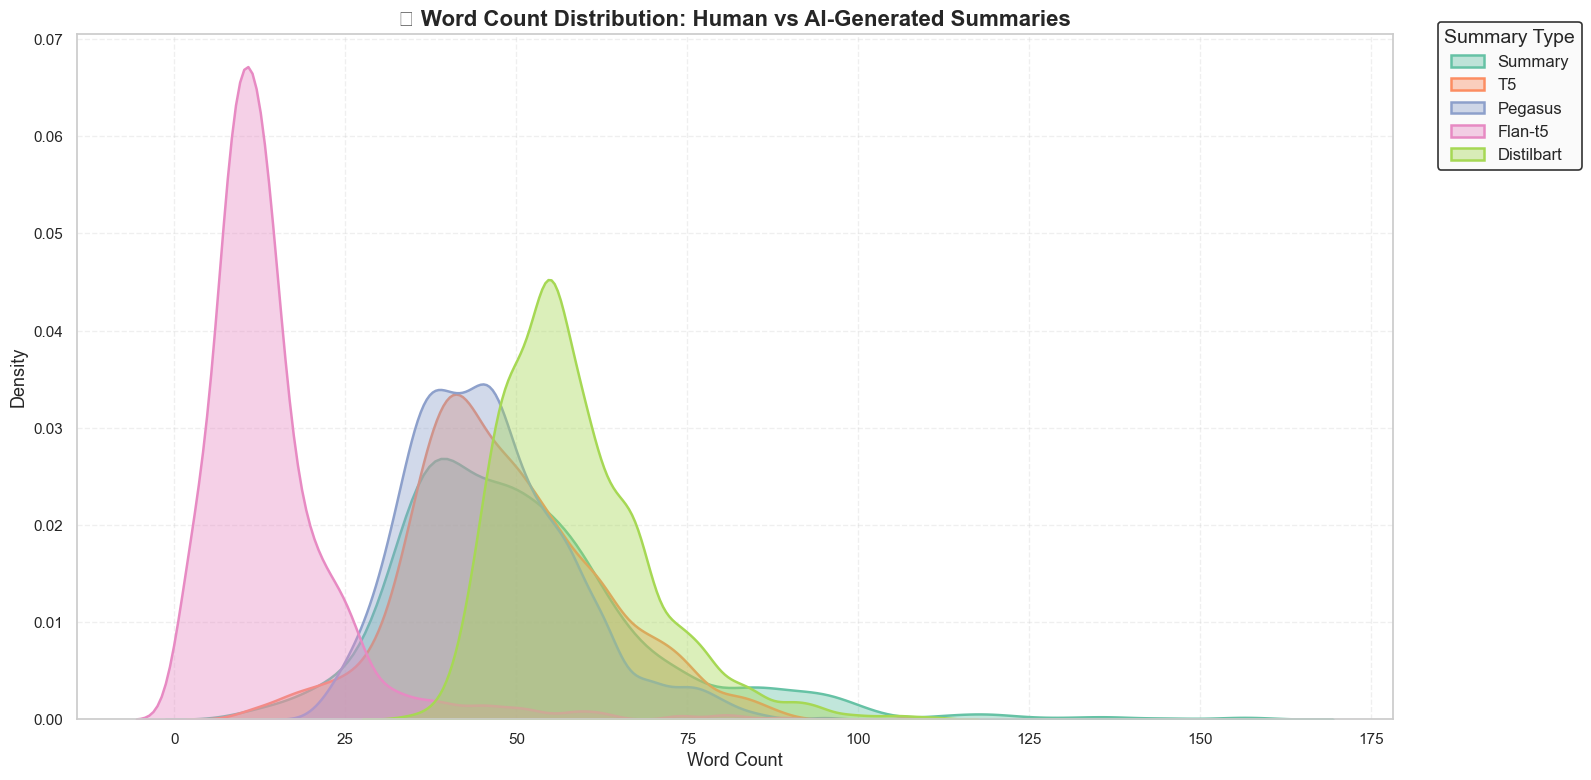

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_word_counts(col):
    return df[col].dropna().apply(lambda x: len(str(x).split()))

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid", font_scale=1.1)

colors = sns.color_palette("Set2", len([reference_col] + model_cols))

for idx, col in enumerate([reference_col] + model_cols):
    word_counts = get_word_counts(col)
    sns.kdeplot(
        word_counts,
        label=col.replace('_summary', '').capitalize(),
        fill=True,
        alpha=0.4,              
        linewidth=1.8,
        color=colors[idx],
        bw_adjust=0.8           
    )

plt.title("📚 Word Count Distribution: Human vs AI-Generated Summaries", fontsize=16, weight='bold')
plt.xlabel("Word Count", fontsize=13)
plt.ylabel("Density", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)

# Stylish legend box in top-right
legend = plt.legend(
    title="Summary Type",
    loc='upper right',
    bbox_to_anchor=(1.15, 1.03),
    frameon=True,
    fontsize=12,
    title_fontsize=14
)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)
legend.get_frame().set_facecolor('#f9f9f9')

plt.tight_layout()
plt.show()

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize
import textstat
model_cols = ['summary', 't5_summary', 'pegasus_summary', 'flan-t5_summary', 'distilbart_summary']
labels = ['Human', 'T5', 'PEGASUS', 'Flan-T5', 'DistilBART']

def count_words(text): return len(word_tokenize(str(text)))
def count_sentences(text): return len(sent_tokenize(str(text)))
def count_chars(text): return len(str(text))
def count_punct(text): return sum(1 for c in str(text) if c in '.,;:!?')

results = {
    'Model': labels,
    'Word Count': [df[col].apply(count_words).mean() for col in model_cols],
    'Sentence Count': [df[col].apply(count_sentences).mean() for col in model_cols],
    'Character Count': [df[col].apply(count_chars).mean() for col in model_cols],
    'Punctuation Count': [df[col].apply(count_punct).mean() for col in model_cols],
    'Readability': [df[col].apply(lambda x: textstat.flesch_reading_ease(str(x))).mean() for col in model_cols],
    'Compression Ratio': [df[col].apply(count_words).mean() / df['text'].apply(count_words).mean() for col in model_cols]
}
metrics_df = pd.DataFrame(results)

In [9]:
metrics_df.to_csv('metrics.csv')

# Statistical Analysis


In [10]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({"axes.titleweight": "bold", "axes.labelweight": "bold"})


In [11]:
eval_df   = pd.read_csv("evaluation_scores.csv").drop(columns=['Unnamed: 0'])
metrics_df = pd.read_csv("metrics.csv").drop(columns=['Unnamed: 0'])

In [12]:
metrics_df.rename(columns={"Model": "Model Type"}, inplace=True)

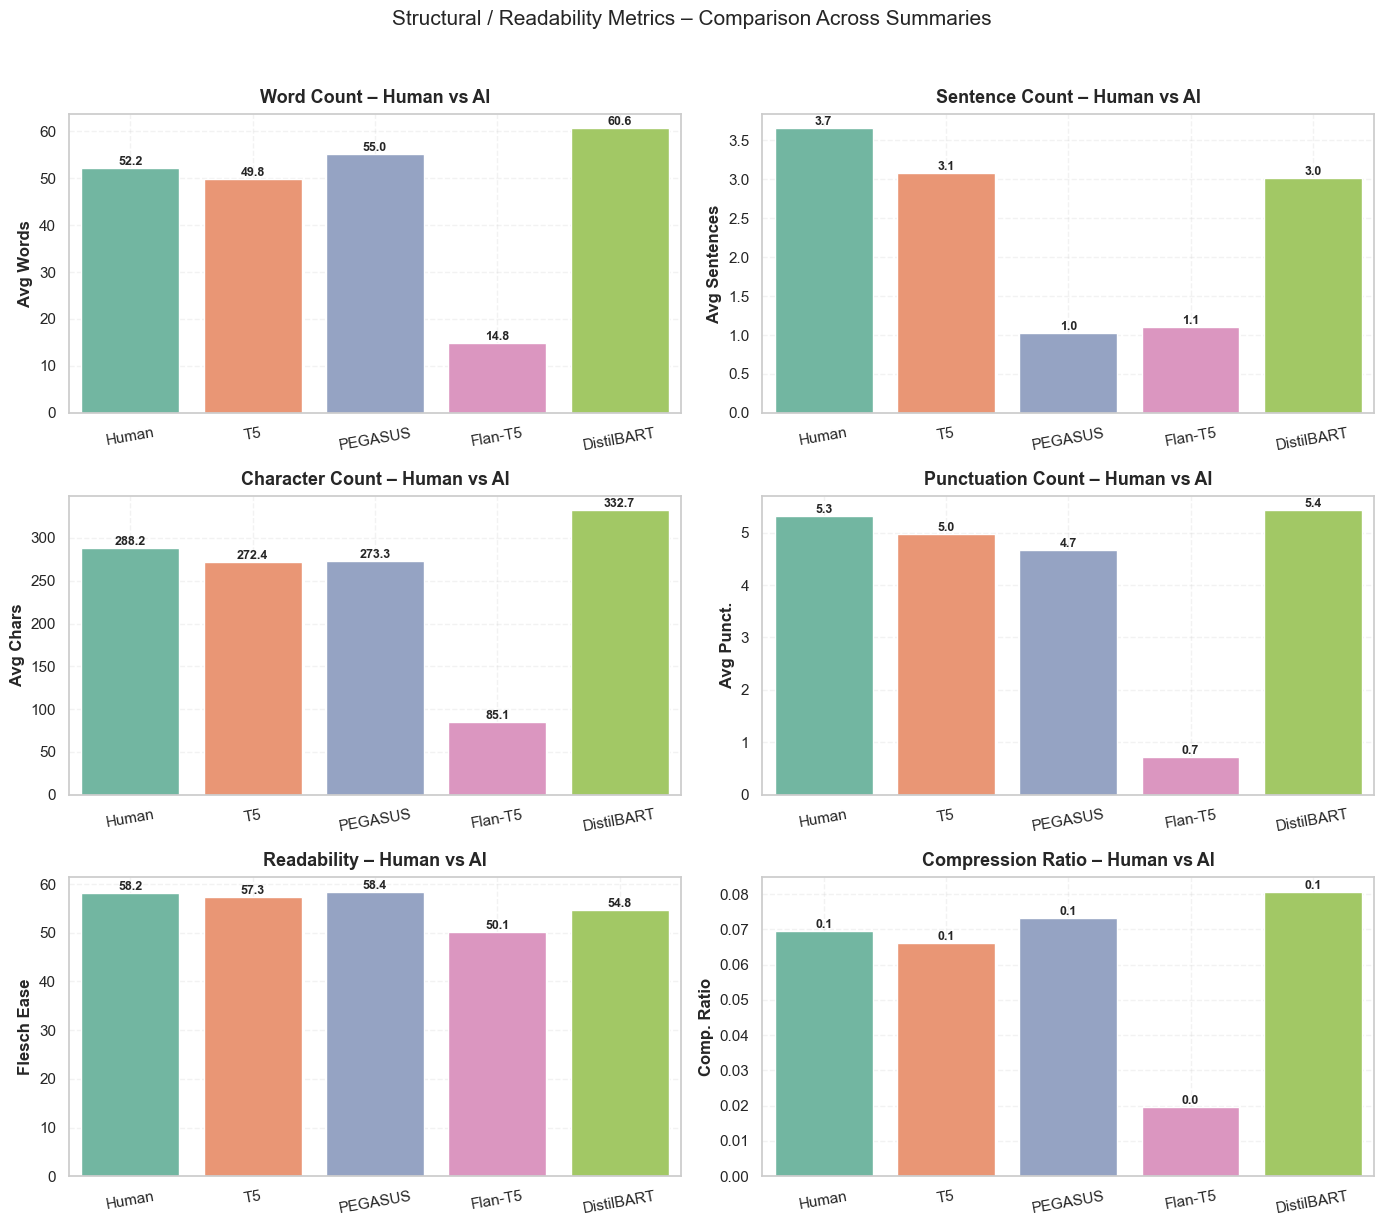

In [13]:
metric_pairs = [
    ("Word Count",          "Avg Words"),
    ("Sentence Count",      "Avg Sentences"),
    ("Character Count",     "Avg Chars"),
    ("Punctuation Count",   "Avg Punct."),
    ("Readability",         "Flesch Ease"),
    ("Compression Ratio",   "Comp. Ratio")
]
palette = sns.color_palette("Set2", n_colors=len(metrics_df))

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, (col, ylab) in zip(axes, metric_pairs):
    bars = sns.barplot(
        data=metrics_df, x="Model Type", y=col, hue="Model Type",
        palette=palette, legend=False, ax=ax
    )
    ax.set_title(f"{col} – Human vs AI", fontsize=13, pad=8)
    ax.set_ylabel(ylab);  ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=10)
    # value labels
    for p in bars.patches:
        h = p.get_height(); x = p.get_x()+p.get_width()/2
        ax.annotate(f"{h:.1f}", (x, h), ha="center", va="bottom", fontsize=9, fontweight="bold")
    ax.grid(alpha=.25, linestyle="--")

fig.suptitle("Structural / Readability Metrics – Comparison Across Summaries", fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

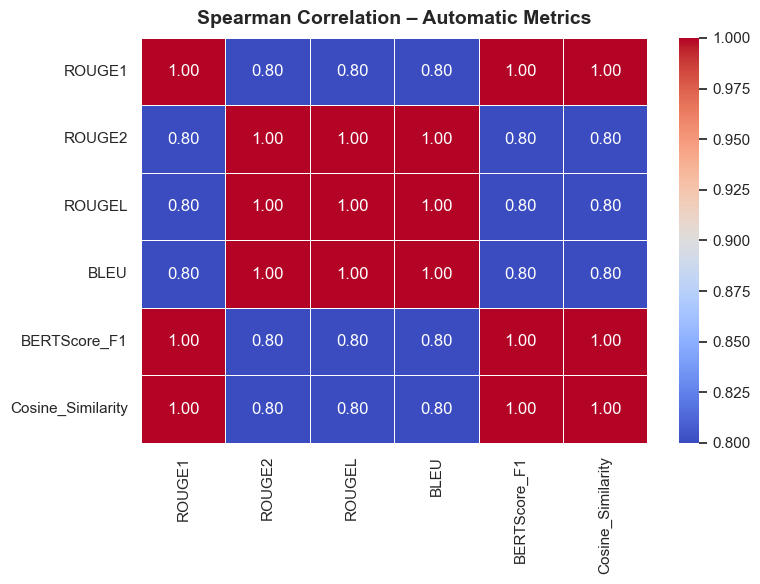

In [14]:
heat_cols = ['ROUGE1', 'ROUGE2', 'ROUGEL', 'BLEU',
             'BERTScore_F1', 'Cosine_Similarity']
plt.figure(figsize=(8,6))
corr = eval_df[heat_cols].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Spearman Correlation – Automatic Metrics", fontsize=14, pad=10, weight='bold')
plt.tight_layout();  plt.show()

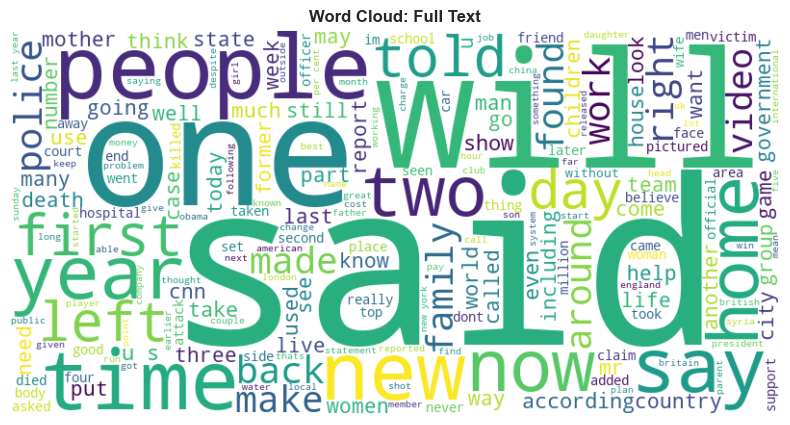

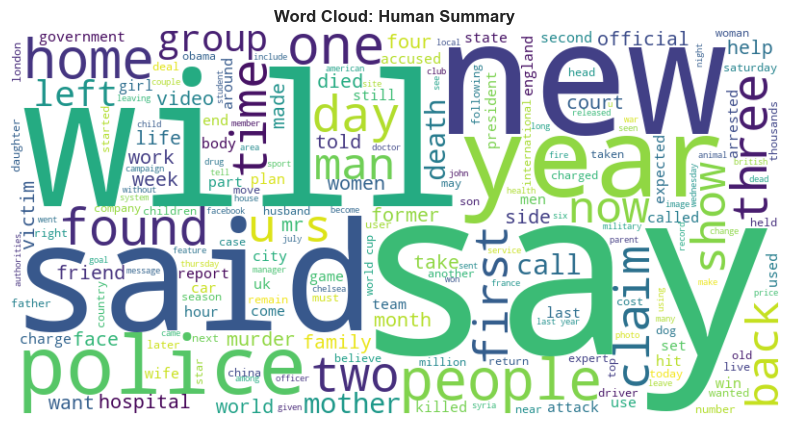

In [15]:
from wordcloud import WordCloud

text_corpus = " ".join(df['text'].astype(str))
sum_corpus = " ".join(df['summary'].astype(str))

for title, corpus in [('Full Text','text_corpus'), ('Human Summary','sum_corpus')]:
    wc = WordCloud(width=800, height=400, background_color='white').generate(locals()[corpus])
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Word Cloud: {title}")
    plt.axis('off')
    plt.show()


# Jaccard Similarity


In [16]:
import pandas as pd
import textdistance
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_summaries(df, model_columns, reference_col='summary', source_col='text'):
    records = []

    for model in model_columns:
        jaccard_scores = []
        levenshtein_dists = []
        compression_ratios = []
        retentions = []

        for _, row in df.iterrows():
            model_text = str(row[model])
            human_text = str(row[reference_col])
            source_text = str(row[source_col])

            # Jaccard Similarity
            vectorizer = CountVectorizer(binary=True)
            try:
                vecs = vectorizer.fit_transform([model_text, human_text]).toarray()
                jaccard = sum(vecs[0] & vecs[1]) / sum(vecs[0] | vecs[1]) if sum(vecs[0] | vecs[1]) != 0 else 0
            except:
                jaccard = 0
            jaccard_scores.append(jaccard)

            # Levenshtein Distance
            lev_dist = textdistance.levenshtein(model_text, human_text)
            levenshtein_dists.append(lev_dist)

            # Compression Ratio
            source_len = len(source_text.split())
            model_len = len(model_text.split())
            compression = model_len / source_len if source_len else 0
            compression_ratios.append(compression)

            # Retention (placeholder: using ROUGE-L if available, otherwise 0)
            retention = row.get('ROUGE_L', 0)
            retentions.append(retention)

        # Aggregate stats for each model
        records.append({
            'Model': model,
            'Jaccard Similarity': round(sum(jaccard_scores)/len(jaccard_scores), 4),
            'Levenshtein Distance': round(sum(levenshtein_dists)/len(levenshtein_dists), 2),
            'Compression Ratio': round(sum(compression_ratios)/len(compression_ratios), 4),
            'Retention': round(sum(retentions)/len(retentions), 4)
        })

    return pd.DataFrame(records)

# Example usage:
df = pd.read_csv(r"C:\Users\sapan\Desktop\laptop4\multi_model_summaries.csv", engine="python", on_bad_lines='skip')
model_cols = ['t5_summary', 'pegasus_summary', 'flan-t5_summary', 'distilbart_summary']
metrics_df = evaluate_summaries(df, model_cols)

print(metrics_df)

                Model  Jaccard Similarity  Levenshtein Distance  \
0          t5_summary              0.2610                211.77   
1     pegasus_summary              0.2552                216.96   
2     flan-t5_summary              0.1300                234.95   
3  distilbart_summary              0.2502                241.75   

   Compression Ratio  Retention  
0             0.0885        0.0  
1             0.0856        0.0  
2             0.0275        0.0  
3             0.1088        0.0  


C:\Users\sapan\AppData\Local\Temp\ipykernel_30392\3763733840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric_name, palette='viridis')


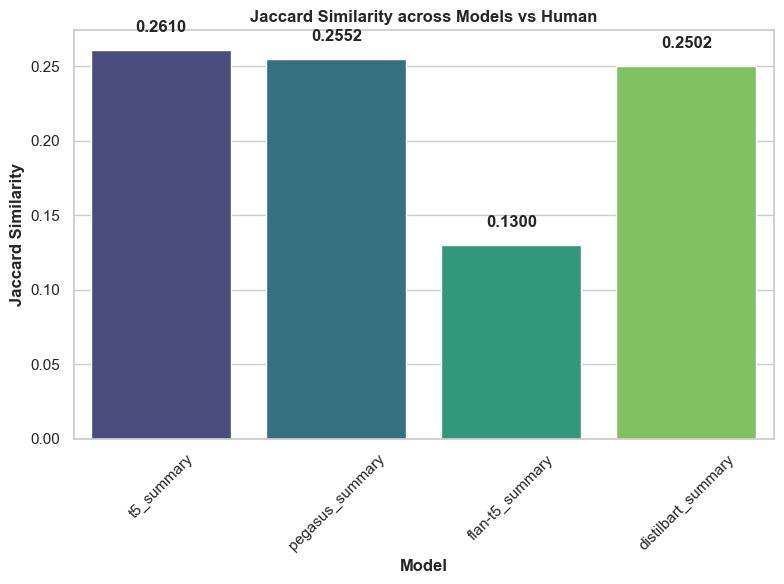

C:\Users\sapan\AppData\Local\Temp\ipykernel_30392\3763733840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric_name, palette='viridis')


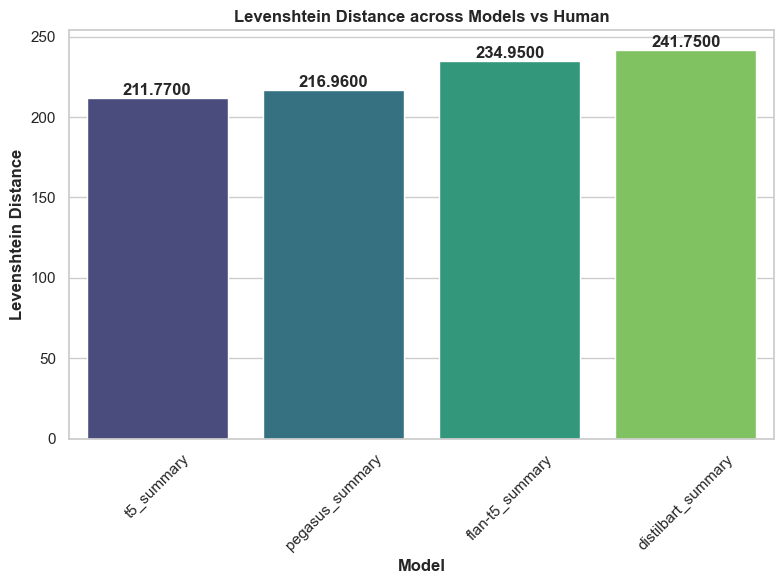

C:\Users\sapan\AppData\Local\Temp\ipykernel_30392\3763733840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric_name, palette='viridis')


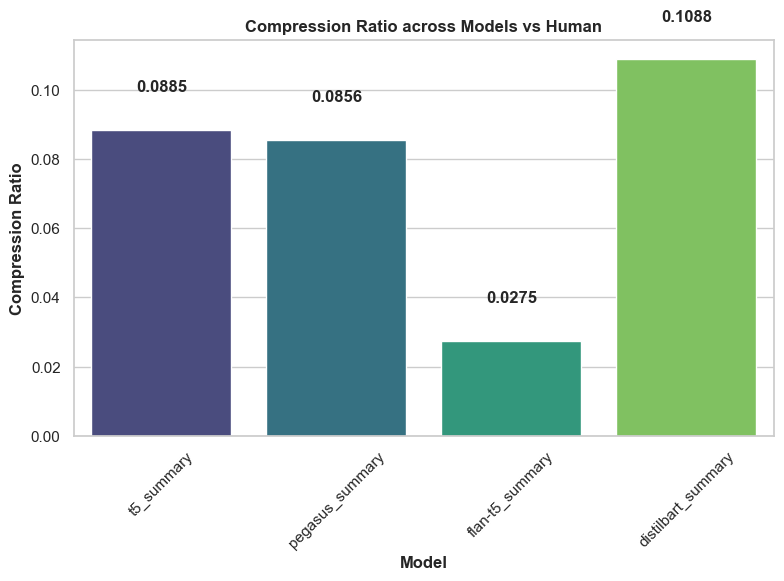

C:\Users\sapan\AppData\Local\Temp\ipykernel_30392\3763733840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric_name, palette='viridis')


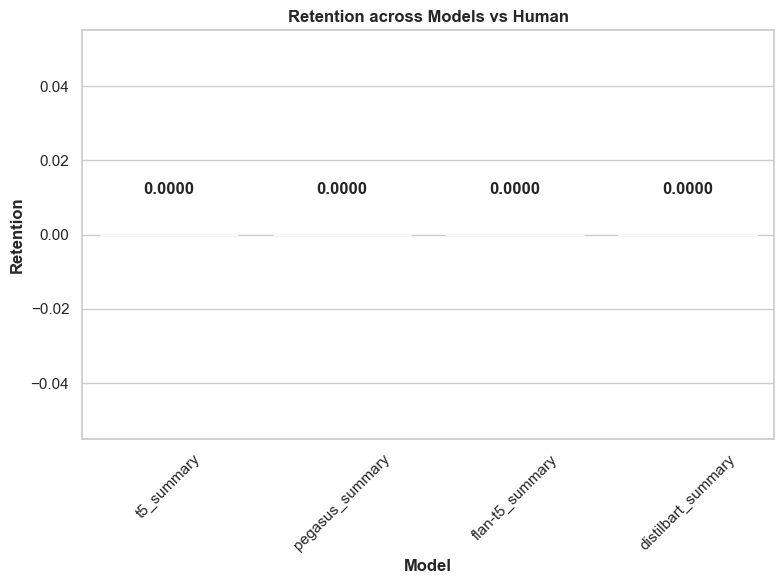

In [17]:
def plot_metric_bars(metrics_df, metric_name):
    plt.figure(figsize=(8,6))
    sns.barplot(data=metrics_df, x='Model', y=metric_name, palette='viridis')
    plt.title(f'{metric_name} across Models vs Human')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)

    # Add value labels
    for index, row in metrics_df.iterrows():
        plt.text(index, row[metric_name] + 0.01, f"{row[metric_name]:.4f}", ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Plot each metric
for metric in ['Jaccard Similarity', 'Levenshtein Distance', 'Compression Ratio', 'Retention']:
    plot_metric_bars(metrics_df, metric)

In [18]:
import pandas as pd
from scipy.stats import f_oneway

def run_anova_all_metrics(df, group_col='Model'):
    results = []

    # Select only numeric columns
    numeric_cols = df.select_dtypes(include='number').columns

    for metric in numeric_cols:
        # Group values by model
        grouped = df.groupby(group_col)[metric].apply(list)

        # Only run ANOVA if all groups have at least 2 values
        if all(len(vals) >= 2 for vals in grouped):
            f_stat, p_val = f_oneway(*grouped)
            results.append({
                'Metric': metric,
                'F-statistic': round(f_stat, 4),
                'p-value': round(p_val, 4)
            })
        else:
            results.append({
                'Metric': metric,
                'F-statistic': None,
                'p-value': None,
                'Note': 'Insufficient data in one or more groups'
            })

    return pd.DataFrame(results)

# Example usage:
metrics_df = pd.read_csv("metrics.csv")  # Replace with your actual path
anova_results = run_anova_all_metrics(metrics_df)
print(anova_results)

              Metric F-statistic p-value  \
0         Unnamed: 0        None    None   
1         Word Count        None    None   
2     Sentence Count        None    None   
3    Character Count        None    None   
4  Punctuation Count        None    None   
5        Readability        None    None   
6  Compression Ratio        None    None   

                                      Note  
0  Insufficient data in one or more groups  
1  Insufficient data in one or more groups  
2  Insufficient data in one or more groups  
3  Insufficient data in one or more groups  
4  Insufficient data in one or more groups  
5  Insufficient data in one or more groups  
6  Insufficient data in one or more groups  
